In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MultipleLocator, MaxNLocator
import seaborn as sns
from ast import literal_eval
from pathlib import Path
from itertools import product
from joblib import Parallel, delayed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from matplotlib.ticker import MaxNLocator

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)

In [2]:
dataset_names = {42900: "Breast Cancer Coimbra",
                 41945: "Indian Liver Patients",
                 "thorax": "Coronary Heart Disease"}

In [3]:
# load all files
df = pd.concat((pd.read_csv(f) for f in Path("../results").glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
df = df.drop("params",axis=1)
df["test_brier"] = -df["test_brier"]
df["train_brier"] = -df["train_brier"]
# eval columns
struct_cols = ['score_set',"stage_clf_params"]
df[struct_cols] = df[struct_cols].map(literal_eval)

# clean some stuff
df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")


In [12]:
label_mapping={"lookahead":"Lookahead",
            "method":"Method",
            "score_set": "Score Set",
            "calibration_method": "Calibration",
            "('calibration_method', 'isotonic')":"Isotonic Regression",
            "beta":"Beta Calibration",
            "psl_prebin":"Prebinarization",
            "psl":"In-Search Binarization",
            "psl_logreg": "Stagewise Logistic Regression",
            "stage":"Stage",
            "train_ent":"Expected Entropy",
            "clf_variant": "Variant",
            "bisect":"Bisect",
            "brute":"Bruteforce",
            "test_brier" : "Brier Score",
            "('calibration_method', 'beta')":"Beta Calibration",
            "(('calibration_method', 'beta'), 'psl')":"PSL Beta Calibration", 
            "(('calibration_method', 'isotonic'), 'psl')":"PSL Isotonic Regression",
            "(('calibration_method', 'isotonic'), 'psl_logreg')": "Stagewise Logistic Regression",
            "test_roc" : "ROC AUC",
            "train_roc" : "ROC AUC",
            "soft_ranking_loss": "Soft Rank Loss",
            "expected_entropy":"Expected Entropy",
            }

score_set_strings = [str(s) for s in list(df.score_set.unique())]
score_set_latex_labels = [f"$\mathcal{{S}}=\{{{s[1:-1]}\}}$" for s in score_set_strings]

label_mapping.update(dict(zip(score_set_strings,score_set_latex_labels)))
label_mapping


{'lookahead': 'Lookahead',
 'method': 'Method',
 'score_set': 'Score Set',
 'calibration_method': 'Calibration',
 "('calibration_method', 'isotonic')": 'Isotonic Regression',
 'beta': 'Beta Calibration',
 'psl_prebin': 'Prebinarization',
 'psl': 'In-Search Binarization',
 'psl_logreg': 'Stagewise Logistic Regression',
 'stage': 'Stage',
 'train_ent': 'Expected Entropy',
 'clf_variant': 'Variant',
 'bisect': 'Bisect',
 'brute': 'Bruteforce',
 'test_brier': 'Brier Score',
 "('calibration_method', 'beta')": 'Beta Calibration',
 "(('calibration_method', 'beta'), 'psl')": 'PSL Beta Calibration',
 "(('calibration_method', 'isotonic'), 'psl')": 'PSL Isotonic Regression',
 "(('calibration_method', 'isotonic'), 'psl_logreg')": 'Stagewise Logistic Regression',
 'test_roc': 'ROC AUC',
 'train_roc': 'ROC AUC',
 'soft_ranking_loss': 'Soft Rank Loss',
 'expected_entropy': 'Expected Entropy',
 '(1,)': '$\\mathcal{S}=\\{1,\\}$',
 '(-3, -2, -1, 1, 2, 3)': '$\\mathcal{S}=\\{-3, -2, -1, 1, 2, 3\\}$',
 '(

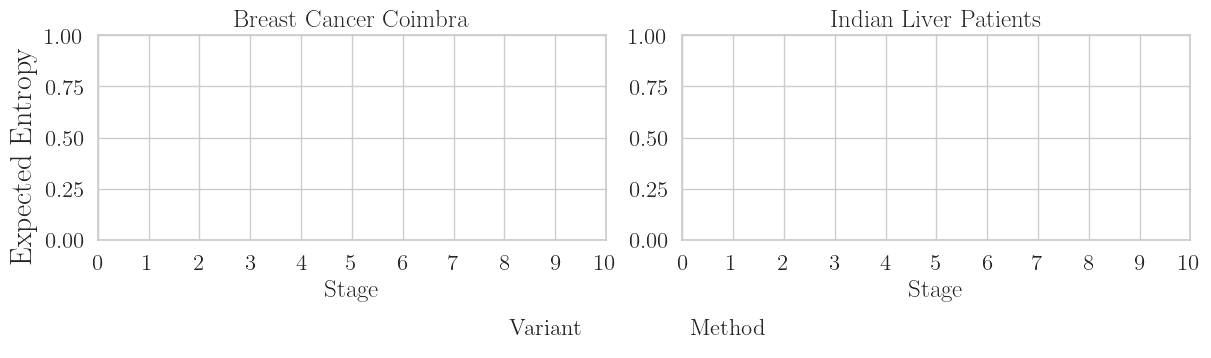

In [13]:
datasets = [42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets), layout="constrained")
axes = axes.ravel()

for index, dataset in enumerate(datasets):
    ax=axes[index]
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl","psl_prebin"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss.isnull())]
    # print(df_["method"].value_counts())
    sns.lineplot(data=df_, x="stage", y="train_ent", hue="clf_variant", style="method", marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Entropy")
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.18), frameon=False)
plt.savefig("binarization.pdf", bbox_extra_artists=(lgd,syl), bbox_inches="tight")

[(('calibration_method', 'isotonic'), 'psl')
 (('calibration_method', 'isotonic'), 'psl_logreg')
 (('calibration_method', 'beta'), 'psl')]
2650
[(('calibration_method', 'beta'), 'psl')
 (('calibration_method', 'isotonic'), 'psl')
 (('calibration_method', 'isotonic'), 'psl_logreg')]
2400
[(('calibration_method', 'isotonic'), 'psl')
 (('calibration_method', 'isotonic'), 'psl_logreg')
 (('calibration_method', 'beta'), 'psl')]
2650


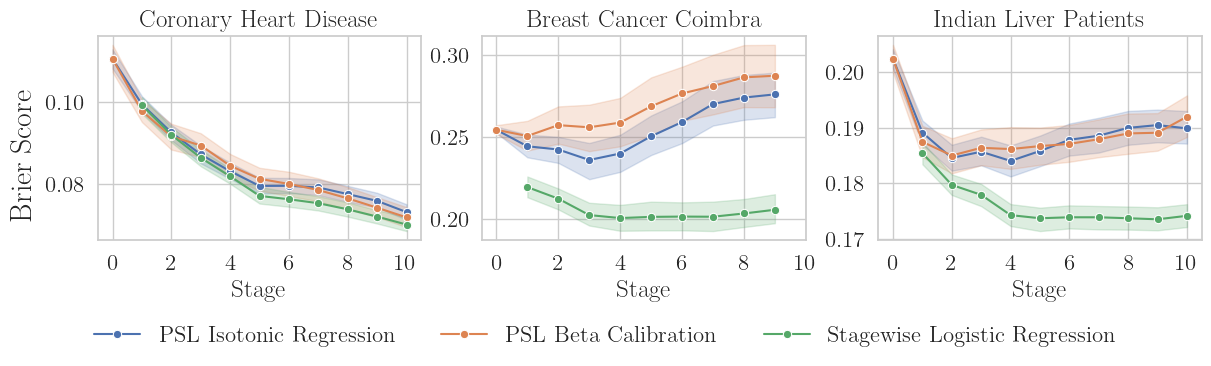

In [14]:
datasets = ["thorax", 42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (~df.stage.isnull())]
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.stage_clf_params==('calibration_method', 'beta'))].index)
    hue_order = [(('calibration_method', 'isotonic'), 'psl'), (('calibration_method', 'beta'), 'psl'), (('calibration_method', 'isotonic'), 'psl_logreg')]
    print(df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    sns.lineplot(data=df_, x="stage", y="test_brier", hue=df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1), hue_order=hue_order, marker="o", ax=ax)
    print(len(df_))
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Brier Score")
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("../fig/brier.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

2150
score_set
(-3, -2, -1, 1, 2, 3)    1050
(-2, -1, 1, 2)            550
(-1, 1)                   550
Name: count, dtype: int64
1950
score_set
(-3, -2, -1, 1, 2, 3)    950
(-1, 1)                  500
(-2, -1, 1, 2)           500
Name: count, dtype: int64
2150
score_set
(-3, -2, -1, 1, 2, 3)    1050
(-2, -1, 1, 2)            550
(-1, 1)                   550
Name: count, dtype: int64


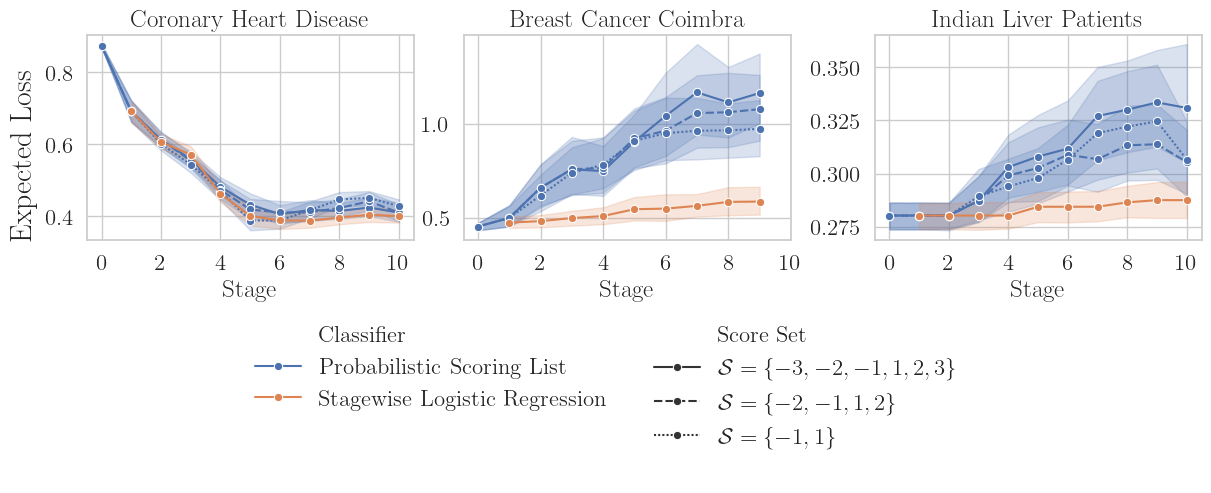

In [33]:
from matplotlib.lines import Line2D

datasets = ["thorax", 42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets), sharey=False, layout='constrained')
axes = axes.ravel()

hue_order = ["psl", "psl_logreg"]
style_order = [(-3, -2, -1, 1, 2, 3), (-2, -1, 1, 2), (-1, 1)]

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    # & (df.score_set.isin([(1),(1,2),(1, 2, 3)]))
    & (df.lookahead.isin({None,1}))
    & (df.clf_variant.isin(["psl", "psl_logreg"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())
    & (df.stage_loss=="expected_entropy")]
    df_ = df_.drop(df_[(df_.clf_variant=="psl_logreg") & (df_.score_set!=(-3,-2,-1,1,2,3))].index)
    # print(df_[["stage_clf_params", "clf_variant"]].apply(tuple, axis=1).unique())
    sns.lineplot(data=df_, x="stage", y="test_wloss", hue="clf_variant", style="score_set", hue_order=hue_order, style_order=style_order, marker="o", ax=ax)
    print(len(df_))
    print(df_.score_set.value_counts())
    # df__ = df_[df_.method == "psl_logreg"]
    # print(df__.score_set.value_counts())
    # print(df__.score_set.value_counts())
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
syl = fig.supylabel("Expected Loss")
label_mapping["psl"] = "Probabilistic Scoring List"
label_mapping["clf_variant"] = "Classifier"

handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
proxy = Line2D([], [], linestyle='-', linewidth=0, color='white')
handles.insert(3,proxy)
handles.insert(3,proxy)
labels.insert(3," ")
labels.insert(3," ")
lgd = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("../fig/expected_loss.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

stage_loss
soft_ranking_loss    550
expected_entropy     550
Name: count, dtype: int64
stage_loss
expected_entropy     500
soft_ranking_loss    500
Name: count, dtype: int64
stage_loss
soft_ranking_loss    550
expected_entropy     550
Name: count, dtype: int64


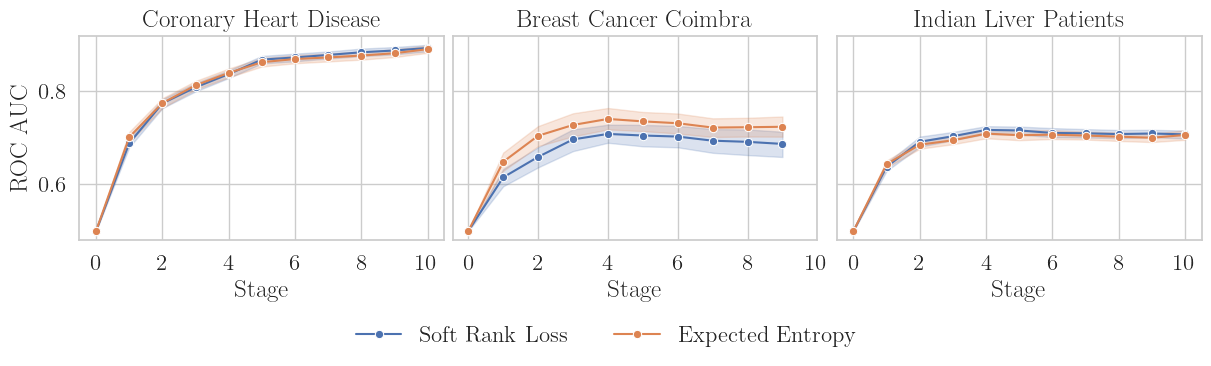

In [16]:
datasets = ["thorax", 42900, 41945]
metric="train_ent"

fig,axes = plt.subplots(1,len(datasets), sharey=True, layout="constrained")
axes = axes.ravel()
hue_order = ["expected_entropy","soft_ranking_loss"]
for index, dataset in enumerate(datasets):
    ax=axes[index]
    df["stage_loss"] = df["stage_loss"].fillna("expected_entropy")
    df_ = df[
    (df.dataset == datasets[index])
    & (df.score_set==(-3, -2, -1, 1, 2, 3)) 
    & (df.lookahead.isin({None,1})) 
    & (df.clf_variant.isin(["psl"]))
    & (df.method.isin(["bisect"]))
    & (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
    & (~df.stage.isnull())]
    # & (df.stage_loss.isin([None, "soft_rank_loss"]))]
    print(df_.stage_loss.value_counts())
    sns.lineplot(data=df_, x="stage", y="test_roc", hue="stage_loss", marker="o", ax=ax)
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(label_mapping["test_roc"])
    ax.set_xlabel("Stage")
    ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
handles, labels = ax.get_legend_handles_labels()
labels = [label_mapping[label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("../fig/roc_auc.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

In [9]:
# Create example run

from skpsl.estimators import ProbabilisticScoringSystem, ProbabilisticScoringList
from experiments.util import DataLoader

RESULTFOLDER = "results"
DATAFOLDER = "data"
scoreset = [0, 1, 2]
dataset = "thorax"

X, y = DataLoader(DATAFOLDER).load(dataset)
psl = ProbabilisticScoringList(score_set=[1,2,3],n_jobs=-1)
psl.fit(X,y)

entropies = []
features = []

for stage_clf in psl.stage_clfs:
    entropies.append(stage_clf.score(X,y))
    features.append(stage_clf.features[-1:])
features = [x[0]+1 if x else None for x in features] 

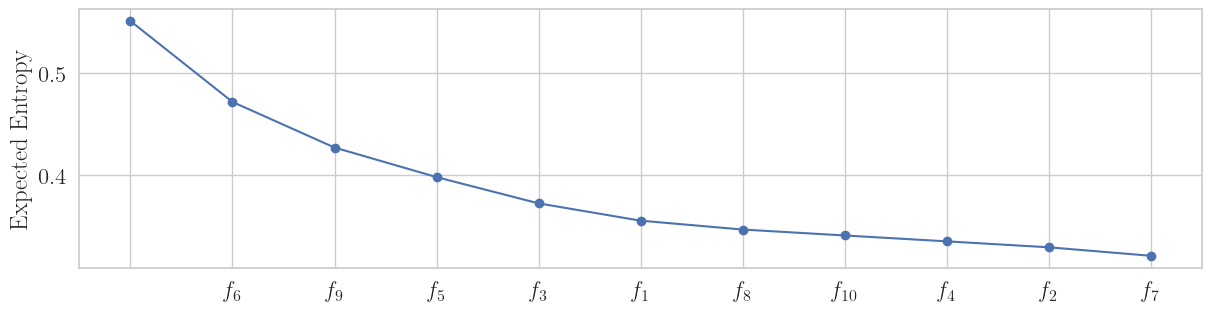

In [10]:
fig, ax = plt.subplots(layout="constrained")
ax.plot(list(range(len(entropies))), entropies, marker="o")
ax.set_xticks(list(range(len(entropies))))
ax.set_xticklabels([rf"$f_{{{feature}}}$" if feature else " " for feature in features])
ax.set_ylabel("Expected Entropy")
plt.savefig("../fig/thorax_example_run.pdf", bbox_inches="tight")